In [ ]:
##Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import os

In [2]:
# Load training and test sets
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Save Passenger IDs for submission
test_ids = test_df['PassengerId']

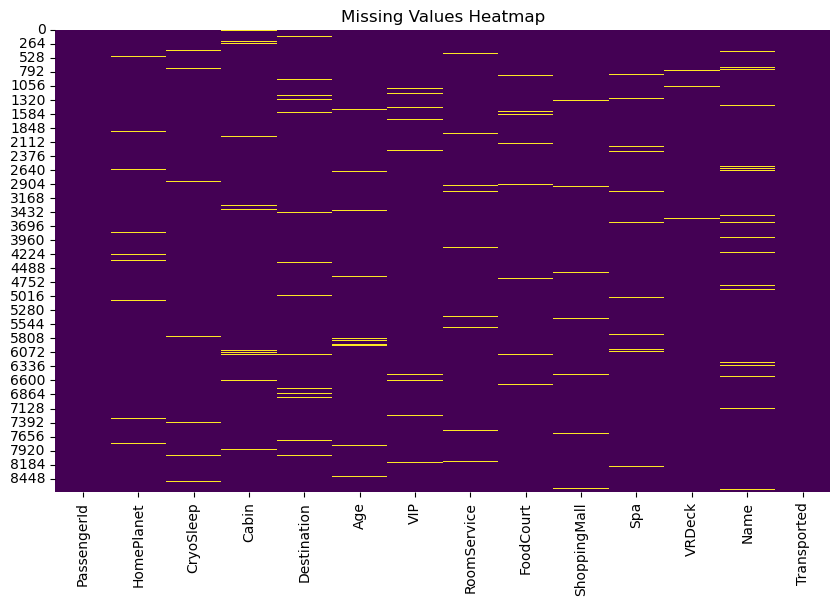

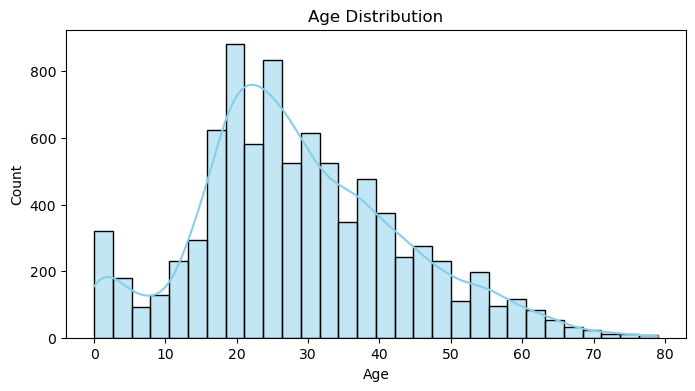

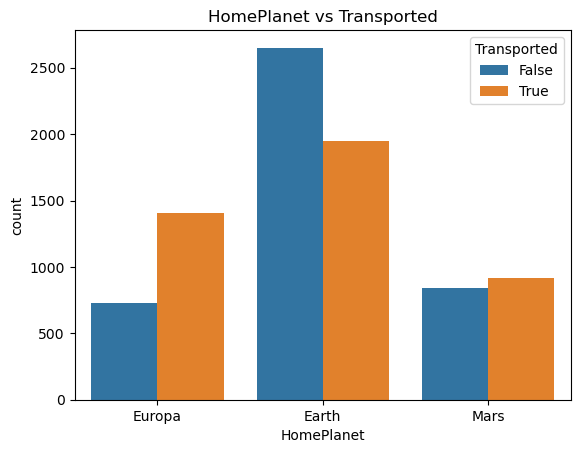

In [3]:
# Overview of missing values
plt.figure(figsize=(10,6))
sns.heatmap(train_df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

# Age distribution
plt.figure(figsize=(8,4))
sns.histplot(train_df['Age'], bins=30, kde=True, color='skyblue')
plt.title("Age Distribution")
plt.show()

# Categorical insights
sns.countplot(data=train_df, x='HomePlanet', hue='Transported')
plt.title("HomePlanet vs Transported")
plt.show()

In [4]:
def preprocess(df):
    df = df.copy()

    # Cabin features
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split('/', expand=True)
    df.drop(['Cabin', 'Name'], axis=1, inplace=True)

    # Boolean conversion
    df['CryoSleep'] = df['CryoSleep'].astype(bool)
    df['VIP'] = df['VIP'].astype(bool)

    # Categorical fill: use most frequent (mode)
    for col in ['HomePlanet', 'Destination', 'Deck', 'Side']:
        df[col] = df[col].fillna(df[col].mode()[0])

    # Numerical fill: use median (robust to outliers)
    df['Age'] = df['Age'].fillna(df['Age'].median())

    # Expense columns: fill with median (avoid using zero)
    expense_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in expense_cols:
        df[col] = df[col].fillna(df[col].median())

    # Optional Feature Engineering
    df['TotalSpend'] = df[expense_cols].sum(axis=1)

    # One-hot encode categoricals
    df = pd.get_dummies(df, drop_first=True)

    return df

In [5]:
X = preprocess(train_df.drop('Transported', axis=1))
y = train_df['Transported']

X_test = preprocess(test_df)
X_test = X_test.reindex(columns=X.columns, fill_value=0)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [8]:
val_preds = model.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print(classification_report(y_val, val_preds))

Validation Accuracy: 0.78953421506613
              precision    recall  f1-score   support

       False       0.79      0.79      0.79       861
        True       0.79      0.79      0.79       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



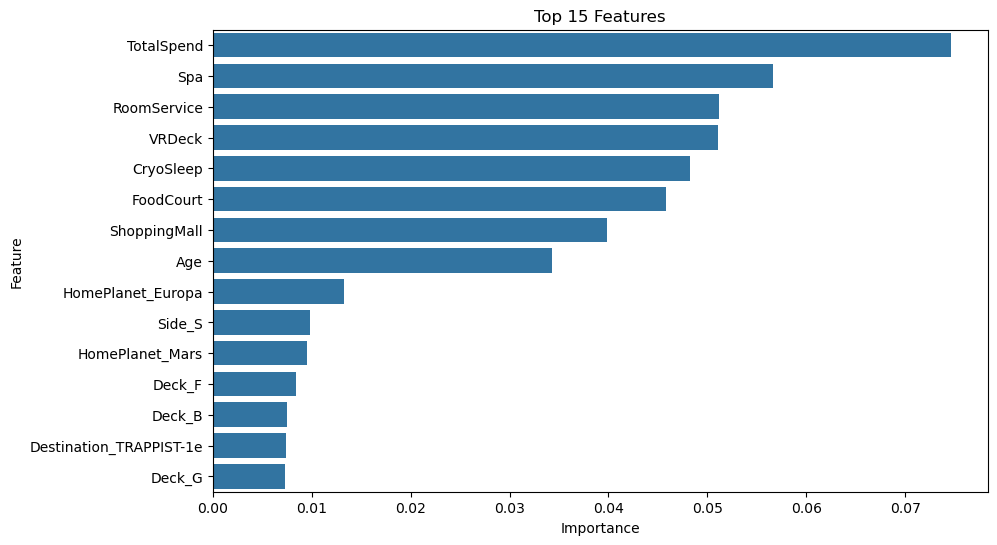

In [9]:
importances = model.feature_importances_
feature_ranking = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_ranking = feature_ranking.sort_values(by='Importance', ascending=False)

# Plot top 15
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_ranking.head(15))
plt.title("Top 15 Features")
plt.show()

In [10]:
test_preds = model.predict(X_test)

In [11]:
joblib.dump(model, 'spaceship_model.pkl')
joblib.dump(X.columns.tolist(), 'spaceship_columns.pkl')

print(f"Model size: {os.path.getsize('spaceship_model.pkl') / 1024 / 1024:.2f} MB")

Model size: 84.17 MB
